In [2]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from datetime import datetime
from scipy.stats import zscore
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt

In [38]:
def read_csvs_to_dfs(directory='./'):
    """
    Reads CSV files from the specified directory and returns a dictionary of DataFrames.
    
    Parameters:
        directory (str): The directory path where the CSV files are located. Default is './' (current directory).
        
    Returns:
        dict: A dictionary where the keys are the file names (without extension) and the values are the corresponding DataFrames.
    """
    dfs = {}
    csv_files = [f for f in listdir(directory) if isfile(join(directory, f)) and f.endswith('.csv')]
    for file in csv_files:
        try:
            df = pd.read_csv(join(directory, file))
            fname = file[:-4]
            if fname == 'NDAQ': ## non-FRED data
                df['DATE'] = pd.to_datetime(df['Date'])
                df.drop(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], inplace = True)
            else:
                df['DATE'] = pd.to_datetime(df['DATE'])
            df = df[df['DATE'] >= '1983-01-01']
            dfs[fname] = df
        except:
            print(file)
    return dfs

data = read_csvs_to_dfs()

In [39]:
def discretize_equal_frequency(data, num_bins=7):
    """
    Discretizes specified columns in each DataFrame within the dictionary using equal-frequency binning.
    
    Parameters:
        data (dict): A dictionary where the keys are the file names and the values are the corresponding DataFrames.
        columns_dict (dict): A dictionary specifying the columns to discretize for each DataFrame.
        num_bins (int): The number of bins to use for discretization. Default is 7.
        
    Returns:
        dict: A dictionary containing the discretized DataFrames.
    """
    discretized_data = {}
    
    for key, df in data.items():
        discretized_df = df.copy()
        for column, series in df.items():
            if column.lower() != 'date':
                discretized_df[column] = pd.to_numeric(series, errors='coerce')
                discretized_df[column + '_bins'] = pd.qcut(discretized_df[column].dropna(), num_bins, labels=False, duplicates='drop')
                discretized_df.drop(columns=[column], inplace = True)
        discretized_data[key] = discretized_df
        
    return discretized_data

equal_frequency_data = discretize_equal_frequency(data)

In [40]:
def discretize_equal_width(data, num_bins=7):
    """
#     Discretizes specified columns in each DataFrame within the dictionary using equal-width binning.
    
#     Parameters:
#         data (dict): A dictionary where the keys are the file names and the values are the corresponding DataFrames.
#         columns_dict (dict): A dictionary specifying the columns to discretize for each DataFrame.
#         num_bins (int): The number of bins to use for discretization. Default is 7.
        
#     Returns:
#         dict: A dictionary containing the discretized DataFrames.
#     """
    discretized_data = {}
    for key, df in data.items():
        discretized_df = df.copy()
        for column, series in df.items():
            if column.lower() != 'date':
                discretized_df[column] = pd.to_numeric(series, errors='coerce')
                discretized_df[column + '_bins'] = pd.cut(discretized_df[column].dropna(), num_bins, labels=False)
                discretized_df.drop(columns=[column], inplace = True)
        discretized_data[key] = discretized_df
    return discretized_data

equal_width_data = discretize_equal_width(data)

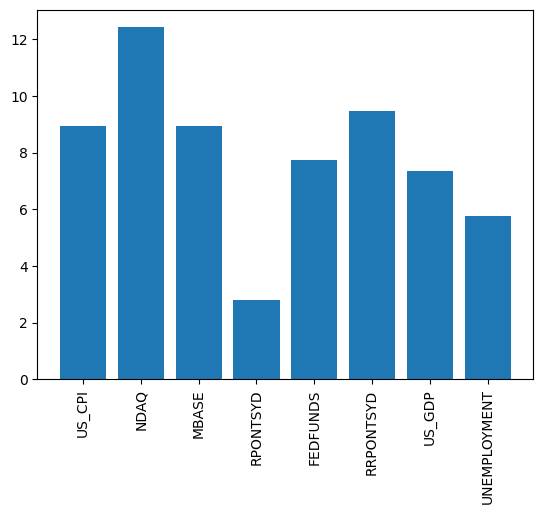

In [41]:
def listToValue(list):
    return list[0]
    
def timeSeriesDataFrameToList(df): ## note: Only accounts for Open of NDAQ data, still a valid data point
    return list(map(listToValue, df.iloc[:,[1]].to_numpy().tolist()))

def calculateEntropy(data):
    """
    Calculates the Shannon entropy of a discretized column in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the discretized data.
        column (str): The name of the discretized column for which to calculate entropy.
        
    Returns:
        float: The calculated entropy value.
    """
    entropy_dict = {}
    for key, df in data.items():
        dataList = timeSeriesDataFrameToList(df)
        points = list(set([dataPoint for dataPoint in dataList]))
        probs = [dataList.count(l)/len(dataList) for l in points]
        entropy_dict[key] = sum([-p*np.log2(p) for p in probs])
    return entropy_dict

calculateEntropy(data)

def barGraphDict(data):
    plt.bar(range(len(data)), list(data.values()), align='center')
    plt.xticks(range(len(data)), list(data.keys()))
    plt.xticks(rotation=90)
    plt.show()

barGraphDict(calculateEntropy(data))

In [42]:
def renameSecondColumn(df, newName):
    return df.rename(columns={df.columns[1]: newName})

def mergeData(data):
    firstDataFrame = 'US_CPI'
    all = renameSecondColumn(data[firstDataFrame], firstDataFrame) ## first
    for k, v in data.items():
        v = renameSecondColumn(v, k)
        if k == firstDataFrame: ## first
            pass
        else:
            all = pd.merge(all, v, how='outer', on='DATE')
    all['DATE'] = all['DATE'].fillna(all['DATE'])
    all.ffill() ## fill forward (only forward) where missing data
    return all.sort_values('DATE')

mergedData = mergeData(equal_frequency_data)

In [43]:
def getMutualInformationScore(xCol, yCol, dataset):
    analysis_dataset = dataset[dataset[xCol].notna()]
    analysis_dataset = analysis_dataset[analysis_dataset[yCol].notna()]
    return mutual_info_score(analysis_dataset[xCol], analysis_dataset[yCol])

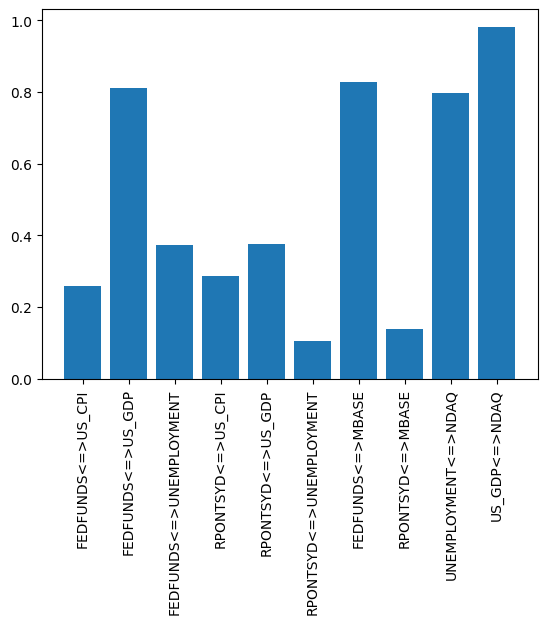

In [44]:
def groupMutualInformationScores(pairs = [
        ['FEDFUNDS', 'US_CPI'],
        ['FEDFUNDS', 'US_GDP'],
        ['FEDFUNDS', 'UNEMPLOYMENT'],
        ['RPONTSYD', 'US_CPI'],
        ['RPONTSYD', 'US_GDP'],
        ['RPONTSYD', 'UNEMPLOYMENT'],
        ['FEDFUNDS', 'MBASE'],
        ['RPONTSYD', 'MBASE'],
        ['UNEMPLOYMENT', 'NDAQ'],
        ['US_GDP', 'NDAQ']
    ]):
    mutualInformation = {}
    for keys in pairs:
        mutualInformation[f"{keys[0]}<=>{keys[1]}"] = getMutualInformationScore(keys[0], keys[1], mergedData)
    return mutualInformation

barGraphDict(groupMutualInformationScores())

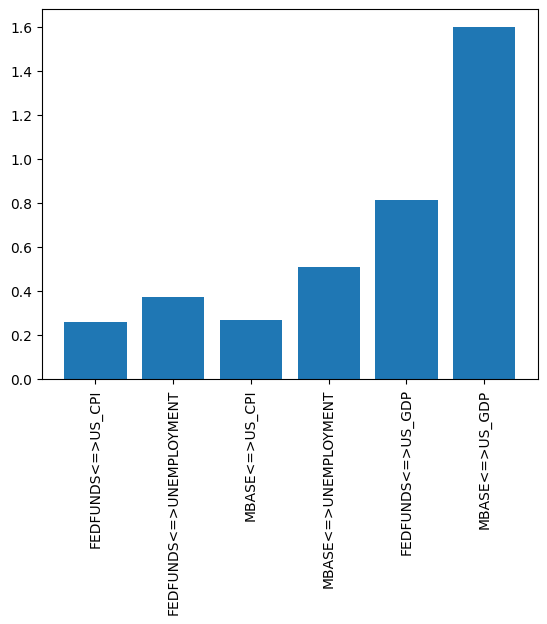

In [45]:
fedGoals = [['FEDFUNDS', 'US_CPI'], ['FEDFUNDS', 'UNEMPLOYMENT'],
            ['MBASE', 'US_CPI'], ['MBASE', 'UNEMPLOYMENT'],
            ['FEDFUNDS', 'US_GDP'], ['MBASE', 'US_GDP']]
barGraphDict(groupMutualInformationScores(fedGoals))

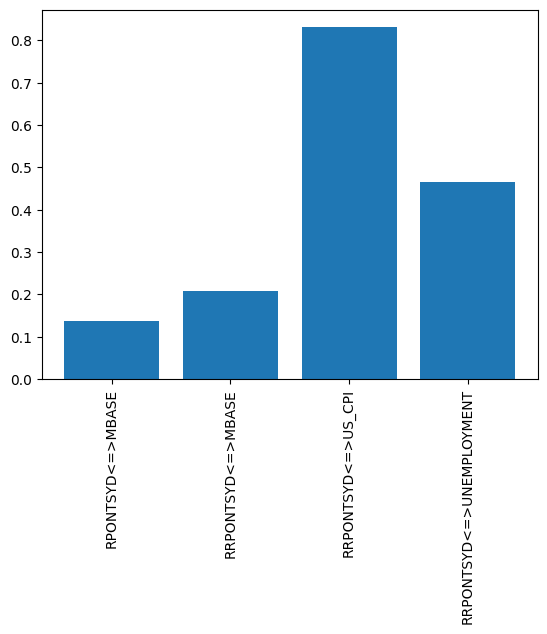

In [46]:
montaryBase = [['RPONTSYD', 'MBASE'], ['RRPONTSYD', 'MBASE'],
            ['RRPONTSYD', 'US_CPI'], ['RRPONTSYD', 'UNEMPLOYMENT']]
barGraphDict(groupMutualInformationScores(montaryBase))